# Trabalho Final - Aprendizado de Máquina
Ianka Karúzia Rabelo de Oliveira - 365560

O Trabalho se trata de uma **Análise de Sentimento**, onde será classificado se certa Review presente no dataset foi positiva (1) ou negativa (0), também será predito quão **Útil** certa Review foi. Ambas predições serão baseadas nos conteúdos da feature **Summary** do dataset, utilizando técnicas de **NLP (Natural Language Processing)**.

No Trabalho será utilizado o Dataset Amazon Fine Food Review, disponível em: https://www.kaggle.com/snap/amazon-fine-food-reviews/data

O dataset contém:
- Reviews de Outubro de 1999 a Outubro de 2012. 
- Um total de 568,454 Reviews
- Cerca de 350MB de Dados
- As features são:
    - Id
    - Product Id
    - User Id
    - Profile Name
    - Helpfulness Numerator
    - Helpfulness Denominator
    - Score
    - Time
    - **Summary: Feature Utilizada nas Predições**
    - Text

Na Análise de Sentimento serão utilizados 3 algorítmos de predição: **Multinomial Naive Bayes**, **Bernoulli Naive Bayes**, **Logistic Regression**. Na análise de Utilidade da Review Será utilizado o algorítmo que apresentar melhor desempenho.

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Carregando os Dados

In [2]:
con = sqlite3.connect('database.sqlite')

pd.read_sql_query("SELECT * FROM Reviews LIMIT 3", con)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#### Excluindo as Features Id, ProductId, UserId, ProfileName, Time e Text, além de renomear as Features HelpfulnessNumerator (VotesHelpful) e HelpfulnessDenominator (VotesTotal)

As Reviews com Score 3 não foram consideradas, pois se tratam de valores de scores intermediários, não tendo como definir se essas Reviews são positivas ou negativas

In [3]:
messages = pd.read_sql_query("""
SELECT 
  Score, 
  Summary, 
  HelpfulnessNumerator as VotesHelpful, 
  HelpfulnessDenominator as VotesTotal
FROM Reviews WHERE Score != 3""", con)

In [4]:
messages.head()

,Score,Summary,VotesHelpful,VotesTotal
0,5,Good Quality Dog Food,1,1
1,1,Not as Advertised,0,0
2,4,"""Delight"" says it all",1,1
3,2,Cough Medicine,3,3
4,5,Great taffy,0,0


Criação da feature com o tamanho das Reviews (SummaryLenght)

In [5]:
messages['SummaryLenght'] = messages['Summary'].apply(len)

In [6]:
messages.head()

,Score,Summary,VotesHelpful,VotesTotal,SummaryLenght
0,5,Good Quality Dog Food,1,1,21
1,1,Not as Advertised,0,0,17
2,4,"""Delight"" says it all",1,1,21
3,2,Cough Medicine,3,3,14
4,5,Great taffy,0,0,11


### Análise Exploratória dos Dados

In [7]:
sns.set_style('white')

#### Usando FaceGrid para criar 5 histogramas do tamanho das reviews de acordo com o valor de Score 

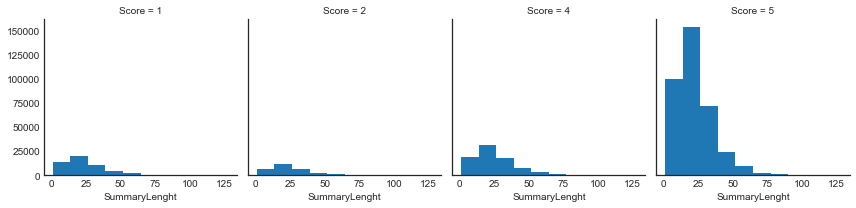

In [8]:
g = sns.FacetGrid(messages, col='Score')
g.map(plt.hist, 'SummaryLenght')

#### Countplot com a quantidade de Reviews de cada tipo de Score

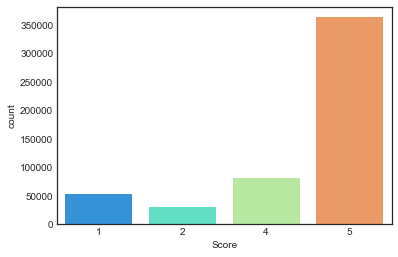

In [9]:
sns.countplot(x='Score', data=messages, palette='rainbow')

#### Utilizando GroupBy para pegar o valor médio das colunas numéricas

In [10]:
scores = messages.groupby('Score').mean()
scores

,VotesHelpful,VotesTotal,SummaryLenght
Score,,,
1,2.735211,4.869825,24.467303
2,1.859014,3.102724,24.899728
4,1.390292,1.666084,24.828988
5,1.675228,1.874108,22.563728


#### Criando um Heatmap baseado nos valores de correlação (.corr) dos dados da variável scores

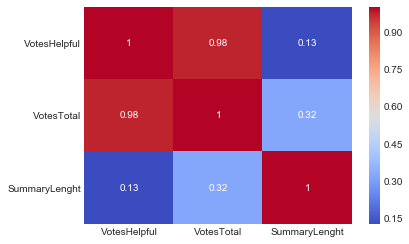

In [11]:
sns.heatmap(scores.corr(), cmap='coolwarm', annot=True)

#### Adicionando a coluna Sentiment que transforma os dados de Score em 1 (Score positivas, ou seja, 4 e 5) e 0 (Scores negativas, 1 e 2)

In [12]:
messages["Sentiment"] = messages["Score"].apply(lambda score: 1 if score > 3 else 0)

#### Na coluna Usefulness foram utilizados os valores das colunas VotesHelpful e VotesTotal para verificar se uma review foi útil (indicado pelo 1) ou não (indicado pelo 0)

In [13]:
messages["Usefulness"] = (messages["VotesHelpful"]/messages["VotesTotal"]).apply(lambda n: 1 if n > 0.8 else 0)

In [14]:
messages[messages.Score == 1].head()

,Score,Summary,VotesHelpful,VotesTotal,SummaryLenght,Sentiment,Usefulness
1,1,Not as Advertised,0,0,17,0,0
12,1,My Cats Are Not Fans of the New Food,1,1,36,0,1
26,1,Nasty No flavor,0,1,15,0,0
47,1,Don't like it,0,7,13,0,0
57,1,stale product.,2,2,14,0,1


In [15]:
messages[messages.Score == 5].head()

,Score,Summary,VotesHelpful,VotesTotal,SummaryLenght,Sentiment,Usefulness
0,5,Good Quality Dog Food,1,1,21,1,1
4,5,Great taffy,0,0,11,1,0
6,5,Great! Just as good as the expensive brands!,0,0,45,1,0
7,5,"Wonderful, tasty taffy",0,0,22,1,0
8,5,Yay Barley,1,1,10,1,1


### Processamento dos Dados Textuais

No Processamento de dados foi útilizado o **SpaCy - Industrial-Strength NLP in Python** para remoção de Pontuações e Espaços em Branco.
Inicialmente foram removidas as Stopwords também, porém os algorítmos apresentaram melhor desempenho sem a remoção das Stopwords

In [16]:
import spacy

In [17]:
nlp = spacy.load('en')

#### Função para Processamento dos textos

In [18]:
def text_process(review):
    # Colocando o Texto em letras Minúsculas
    review_lower = review.lower()
    # Analisando o Texto com Spacy
    parsed_review = nlp(review_lower)
    
    # Removendo Pontuação e Espaços em Branco
    unigram_review = [token for token in parsed_review if not token.is_punct or token.is_space]
    
    
    # Removendo as Stopwords, caso queira utilizar
    #unigram_review = [term for term in unigram_review if not term.is_stop]
    
    # Formando a String após limpeza do Texto
    review_final = ' '.join(map(str,unigram_review))
    
    return review_final

A célula é responsável por realizar a análise das Reviews e colocá-las na feature Summary_Clean, por ser longo, esse processo foi executado uma vez e seus resultados foram salvo no csv **summary_clean_final.csv**  

In [19]:
#messages["Summary_Clean"] = messages["Summary"].apply(text_process)
#Carregar o Arquivo do documento summary_clean.txt

#### Carregamento do csv com as reviews pré-processadas e Concatenação com o dataset original

In [20]:
summary_clean = pd.read_csv('summary_clean_final.csv', index_col=0, sep='\t')

In [21]:
messages = pd.concat([messages, summary_clean], axis=1)

Após o processamento dos textos, suriram alguns NaN que foram de Reviews que continham apenas Emojis feitos com pontuações, que foram eliminados na função text_process, então essas Reviews foram excluidas, já que não eram muitas (107 Reviews), considerando o número total de Reviews (+500000)

In [22]:
messages_final = messages.dropna(axis=0)

#### Utilizando WorldCloud para mostrar as palavras mais frequentes de acordo com seus Scores

In [23]:
from wordcloud import WordCloud

In [24]:
stopwords = nlp.Defaults.stop_words
plt.rcParams['font.size']=12        
plt.rcParams['savefig.dpi']=100 
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

#### WorldCloud para Piores Avaliações (Score == 1)

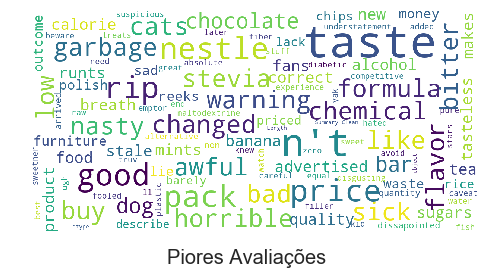

In [25]:
show_wordcloud(messages_final[messages_final.Score == 1]["Summary_Clean"], title = "Piores Avaliações")

#### WordCloud para Melhores Avaliações (Score == 5)

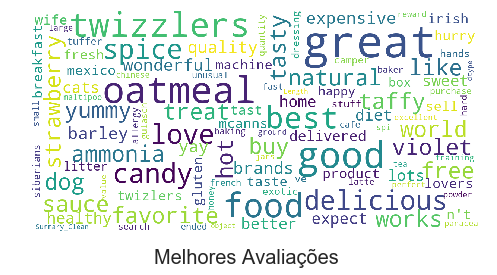

In [26]:
show_wordcloud(messages_final[messages_final.Score == 5]["Summary_Clean"], title = "Melhores Avaliações")

## Predição do Sentimento da Review

#### Definindo Summary_Clean como X e y como Sentiment e realizando train_test_split

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X = messages_final['Summary_Clean']
y = messages_final['Sentiment']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Preparando os dados para os modelos

Para preparação dos dados textuais para utilização nos modelos, foram utilizadas duas técnicas:
- **CountVectorizer**  
Converte uma coleção de Textos em uma matriz de contagem
- **TfidfTransformer**  
TF sinifica Term-Frequency e IDF significa Inverse Document-Frequency. Transforma uma matriz de contagem para uma representação tf-idf normalizada

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [31]:
cv = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [32]:
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_cv)
X_test_tfidf = tfidf.transform(X_test_cv)

### Aplicando os Algorítmos de Predição
Além da Curva ROC, será verificado também a Acurácia dos Algorítmos

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#### Aplicando Multinomial Naive Bayes

In [34]:
model_m = MultinomialNB().fit(X_train_tfidf, y_train)
m_pred = model_m.predict(X_test_tfidf)

In [35]:
m_pred_probabilities = model_m.predict_proba(X_test_tfidf)[:,1]
m_fpr, m_tpr, thresholds = metrics.roc_curve(y_test, m_pred_probabilities)
m_auc = metrics.auc(m_fpr, m_tpr)

In [36]:
print('Acurácia Multinomial NB:', metrics.accuracy_score(y_test, m_pred))

Acurácia Multinomial NB: 0.9168109160310184


#### Aplicando Bernoulli Naive Bayes

In [37]:
model_b = BernoulliNB().fit(X_train_tfidf, y_train)
b_pred = model_b.predict(X_test_tfidf)

In [38]:
b_pred_probabilities = model_b.predict_proba(X_test_tfidf)[:,1]
b_fpr, b_tpr, thresholds = metrics.roc_curve(y_test, b_pred_probabilities)
b_auc = metrics.auc(b_fpr, b_tpr)

In [39]:
print('Acurácia Bernoulli NB:', metrics.accuracy_score(y_test, b_pred))

Acurácia Bernoulli NB: 0.884410289576636


#### Aplicando Logistic Regression

Modelo 1 da Logistic Regression, utilizando os valores padrões

In [40]:
model_lr = LogisticRegression(random_state=42).fit(X_train_tfidf, y_train)
lr_pred = model_lr.predict(X_test_tfidf)

In [41]:
print('Acurácia Logistic Regression 1:', metrics.accuracy_score(y_test, lr_pred))

Acurácia Logistic Regression 1: 0.9448745506077495


Modelo 2 da Logistic Regression ajustando alguns hiper-parâmetros

In [42]:
model_lr2 = LogisticRegression(penalty='l2', C=1e6, random_state=42, tol=0.01, max_iter=200)
model_lr2.fit(X_train_tfidf, y_train)
lr_pred2 = model_lr2.predict(X_test_tfidf)

In [43]:
lr_pred_probabilities = model_lr2.predict_proba(X_test_tfidf)[:,1]
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_pred_probabilities)
lr_auc = metrics.auc(lr_fpr, lr_tpr)

In [44]:
print('Acurácia Logistic Regression 2:', metrics.accuracy_score(y_test, lr_pred2))

Acurácia Logistic Regression 2: 0.9576255603532999


O segundo melhor Kernel desse dataset no Kaggle obteve uma acurácia de 0.9584

#### Comparando os Modelos utilizando a ROC Curve

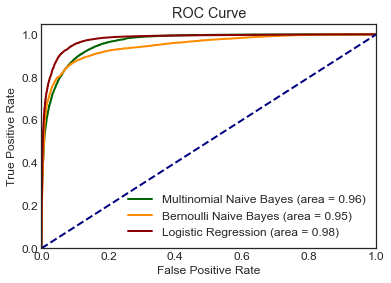

In [45]:
plt.figure()
plt.plot(m_fpr, m_tpr, color='darkgreen',
         lw=2, label='Multinomial Naive Bayes (area = %0.2f)' % m_auc)
plt.plot(b_fpr, b_tpr, color='darkorange',
         lw=2, label='Bernoulli Naive Bayes (area = %0.2f)' % b_auc)
plt.plot(lr_fpr, lr_tpr, color='darkred',
         lw=2, label='Logistic Regression (area = %0.2f)' % lr_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Predição da Utilidade da Review
Nessa predição será utilizado o algorítmo de melhor desempenho encontrado na Análise de Sentimento (Logistic Regression).  
Será usado o mesmo valor de X utilizado na predição anterior, porém o y agora será o valor presente na feature Usefulness. Dessa vez não será nescessário realizar a preparação dos valores de X e y pois será feito através do Pipeline

Antes de iniciar as predições é importante entendermos as duas features (VotesTotal e VotesHelpful) que formam o y (Usefulness).  
No gráfico abaixo é possível observar que grande maioria desses valores se encontram entre 0 e 200, havendo apenas algumas Reviews que foram consideradas úteis.

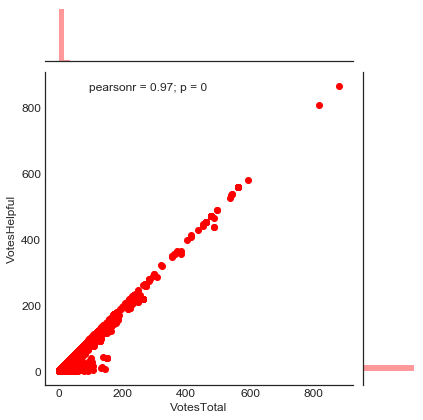

In [46]:
sns.jointplot(x='VotesTotal', y='VotesHelpful', data=messages_final, color='red')

In [47]:
from sklearn.pipeline import Pipeline

Definição dos conjuntos de X e y

In [48]:
X = messages_final['Summary_Clean']
y = messages_final['Usefulness']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Pipeline responsável pela realização das etapas de preparação dos textos (CountVectorize e TfidfTransformer) e da definição do algorítmo de predição (LogisticRegression)

In [50]:
pipe = Pipeline([
    ('vect', CountVectorizer(min_df = 1, ngram_range = (1, 4))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(penalty='l2', C=1e6, random_state=42, tol=0.01, max_iter=200))
])

In [51]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), preprocessor=None, stop_words=None,
        strip...enalty='l2', random_state=42,
          solver='liblinear', tol=0.01, verbose=0, warm_start=False))])

In [52]:
pipe_pred = pipe.predict(X_test)

Acurácia obtida nas predições:

In [53]:
print('Acurácia:', metrics.accuracy_score(y_test,pipe_pred))

Acurácia: 0.7110320645729902


Mostrando a curva ROC para essa predição

In [54]:
pipe_pred_probabilities = pipe.predict_proba(X_test)[:,1]
pipe_fpr, pipe_tpr, _ = metrics.roc_curve(y_test, pipe_pred_probabilities)
pipe_roc_auc = metrics.auc(pipe_fpr, pipe_tpr)

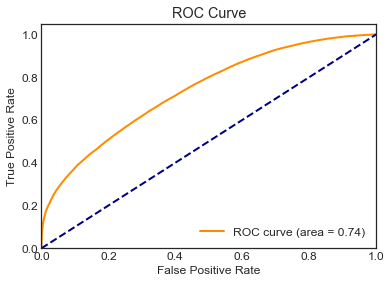

In [55]:
plt.figure()
plt.plot(pipe_fpr, pipe_tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % pipe_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Criando um modelo com o dataset inteiro para realizar a Análise de Sentimento de algumas amostras 
Após refeito as atribuições de X e y, é usado o CountVectorize e o TfidfTransformer para realizar a preparação dos dados para o modelo

In [56]:
X = messages_final['Summary_Clean']
y = messages_final['Sentiment']

In [57]:
cv = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_cv = cv.fit_transform(X)

tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_cv)

In [58]:
model_final = LogisticRegression(penalty='l2', C=1e6, random_state=42, tol=0.01, max_iter=200)
model_final.fit(X_tfidf, y)

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.01, verbose=0, warm_start=False)

In [59]:
def predict_sentiment(sample, model):
    # Realiza a limpeza da amostra
    sample_clean = text_process(sample)
    
    # Transforma numa matriz de contagem
    sample_counts = cv.transform([sample_clean])
    
    # Transforma na representação de TF-IDF normalizada
    sample_tfidf = tfidf.transform(sample_counts)
    
    # Realiza a Predição
    pred = model.predict(sample_tfidf)[0]
    
    if(pred == 1):
        print(sample + ": " + "Review Positiva")
    else:
        print(sample + ": " + "Review Negativa")

In [60]:
sample1 = "The Worst Food in The City!!!"
sample2 = "The Best Food in The City!!!"
sample3 = "The food didn't taste very well, it wasn't what we expected."

In [61]:
predict_sentiment(sample1, model_final)
predict_sentiment(sample2, model_final)
predict_sentiment(sample3, model_final)

The Worst Food in The City!!!: Review Negativa
The Best Food in The City!!!: Review Positiva
The food didn't taste very well, it wasn't what we expected.: Review Negativa


## Conclusões

- **Dificuldades:**
    - Por se tratar de um trabalho de NLP, não abordado na disciplina, foi nescessário um estudo mais aprofundado do assunto, antes de começar o desenvolvimento do trabalho.
    - Levou muito tempo para reaizar a limpeza do dataset para deixá-lo pronto para usar nos algorítmos.
    - Na feature Text, que, inicialmente, seria a analisada existiam muitas tags de html, o que fez com que eu optasse por usar a feature Review, já que, embora tivessem menos conteúdo para analisar, não necessitava de uma limpeza tão complexa quanto a feature Text necessitaria.  
- **Aprendizados:**
    - Conhecimento mais aprofundado sobre NLP e suas técnicas
        - Nltk e SpaCy
        - CountVectorize e TfidfTransformer
    - WorldCloud
    - Pipeline
    - Melhor utilização dos gráficos para análise exploratória dos dados
- **Melhorias Futuras:**
    - Aprimorar a função de limpeza do texto (text_process) para eliminar as tags existentes e realizar a predição utilizado os dados da feature Text, que são mais extensos, melhorando o uso do SpaCy.
    - Tentar uma abordagem utilizando o Word2Vec ou Doc2Vec ao invés do CountVectorize e TfidfTransformer